In [1]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

In [72]:
read_file = pd.read_csv("Raw_Data.csv")

read_file = read_file.iloc[:, :]

data = read_file.transpose()

X = data.iloc[:, :-1]
Y = data.iloc[:, -1]
Y = Y.astype(int)

In [142]:
epsi = 10**-10
X = np.log(X + epsi)
X.replace([np.inf, -np.inf], 0, inplace=True)

In [64]:
# print(np.histogram(X.iloc[:, 1500], bins=100))

In [123]:
print(X.shape)
print(Y.shape)

(1094, 17000)
(1094,)


we have loaded the data to X and Y dataframes.

stage frequency analysis:

In [40]:
Stages = np.zeros(13)
for i in range(Y.size):
    Stages[Y.iloc[i]] += 1
print(Stages)

[189. 621. 250.  35.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


Stage union:

In [73]:
for i in range(Y.size):
    if (Y[i] <= 3):
        Y[i] = 0
    elif (Y[i] <= 6):
        Y[i] = 1
    elif (Y[i] <= 10):
        Y[i] = 2
    else:
        Y[i] = 3

Stage deletion:

In [78]:
SumStages = 0
bar = 90
for i in range(Stages.size):
    if (Stages[i] != 0 or Stages[i] != 3):
        X = X.drop(index=X.iloc[int(SumStages):int(SumStages) + int(Stages[i]), :].index.tolist(), inplace=False)
        Y = Y.drop(index=Y.iloc[int(SumStages):int(SumStages) + int(Stages[i])].index.tolist(), inplace=False)
    else:
        SumStages += Stages[i]

# Stage_counter = 0
# for i in range(Y.size):
#     if (i + 1 < Y.size and Y.iloc[i] != Y.iloc[i + 1]):
#         Y.iloc[i] = Stage_counter
#         Stage_counter += 1
#     else:
#         Y.iloc[i] = Stage_counter

run TSNE:

In [25]:
#X = TSNE(n_components=2, learning_rate='auto', perplexity=3).fit_transform(X)
#df = pd.DataFrame()
#df["y"] = Y
#df["Gene Group 1"] = X[:,0]
#df["Gene Group 2"] = X[:,1]

#sns.scatterplot(x="Gene Group 1", y="Gene Group 2", hue=df.y.tolist(),palette=sns.color_palette("hls", 4),data=df).set(title="TSNE distribution")

In [ ]:
X = preprocessing.StandardScaler().fit_transform(X)

gene STD clean:

In [32]:
bar = 0.5
print("total genes: ", X.shape[1])
X = X.loc[:,X.std(axis=0) > bar]
print("reduced to ", X.shape[1], "genes with STD > ", bar)

total genes:  16995
reduced to  16995 genes with STD >  0.5


SVD clean:

In [74]:
svd = TruncatedSVD(n_components=1094, random_state=42)
X1 = svd.fit_transform(X)
Sigma = np.diag(svd.singular_values_)
V = svd.components_
print(svd.singular_values_)
# X1 = U @ Sigma @ V

[1.27986653e+06 2.10672941e+04 1.74791142e+03 ... 3.67111292e+01
 3.66120794e+01 3.62525614e+01]


In [23]:
#print(np.mean(np.abs(X - X1)))

In [ ]:
print(U.shape)
print(Sigma.shape)
print(V.shape)

(1094, 1094)
(1094, 1094)
(1094, 15115)


In [ ]:
S = pd.DataFrame(svd.singular_values_)
S.to_csv("SVD sigma 1094.csv")
Ucsv = pd.DataFrame(U)
Ucsv.to_csv("SVD U 1094.csv")
Vcsv = pd.DataFrame(V)
Vcsv.to_csv("SVD V 1094.csv")

In [ ]:
bar = 30
per = 0.5
found = [False, False]
for i in range(svd.singular_values_.size):
    if svd.singular_values_[i] < bar and not found[0]:
        print("trauncate at ", i, "for values > ", bar)
        found[0] = True
    elif i/svd.singular_values_.size > per and not found[1]:
        print(per * 100, "% value: ", svd.singular_values_[i-1])
        found[1] = True
    if found[0] and found[1]:
        break
if not found[0]:
    print("all value's are greater then ", bar)

50.0 % value:  69.67584246291554
trauncate at  997 for values >  30


Shuffle data:

In [ ]:
X, Y = shuffle(X, Y, random_state=0)

split to train and test groups:

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

normal distribution:

In [129]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

range distribution:

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

logistical regression:

In [76]:
model = LogisticRegression(random_state=0, max_iter=1000, multi_class="multinomial", n_jobs=-1, C=0.00001, class_weight='balanced')

Logistic Regression Cross Validation

In [56]:
model = LogisticRegressionCV(cv=3, random_state=0, max_iter=100, multi_class="multinomial",class_weight='balanced', n_jobs=-1)

Linear regression:

In [81]:
model = LinearRegression(copy_X=True, n_jobs=-1)

TypeError: LinearRegression.__init__() got an unexpected keyword argument 'max_iter'

train the model:

In [79]:
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
testscore = model.score(X_test, Y_test)
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred))
print("test score: ", testscore)
trainscore = model.score(X_train, Y_train)
print("train score: ", trainscore)

              precision    recall  f1-score   support

           0       0.22      0.49      0.31        39
           1       0.62      0.60      0.61       127
           2       0.27      0.06      0.10        48
           3       0.00      0.00      0.00         5

    accuracy                           0.45       219
   macro avg       0.28      0.29      0.25       219
weighted avg       0.46      0.45      0.43       219



C:\Users\omrin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omrin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omrin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

In [86]:
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
for i in range(Y_pred.shape[0]):
    if Y_pred[i] % 1 < 0.5:
        Y_pred[i] = int(Y_pred[i])
    else:
        Y_pred[i] = int(Y_pred[i] + 1)
testscore = 0
for i in range(Y_pred.shape[0]):
    if Y_pred[i] == Y_test[i]:
        testscore = testscore + 1
testscore = testscore / Y_pred.shape[0]
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred))

Y_pred = model.predict(X_train)
for i in range(Y_pred.shape[0]):
    if Y_pred[i] % 1 < 0.5:
        Y_pred[i] = int(Y_pred[i])
    else:
        Y_pred[i] = int(Y_pred[i] + 1)
trainscore = 0
for i in range(Y_pred.shape[0]):
    if Y_pred[i] == Y_train[i]:
        trainscore = trainscore + 1
trainscore = trainscore / Y_pred.shape[0]
        
print("test score: ", testscore)
trainscore = model.score(X_train, Y_train)
print("train score: ", trainscore)

              precision    recall  f1-score   support

           0       0.26      0.13      0.17        39
           1       0.60      0.69      0.64       127
           2       0.22      0.23      0.22        48
           3       0.00      0.00      0.00         5

    accuracy                           0.47       219
   macro avg       0.27      0.26      0.26       219
weighted avg       0.44      0.47      0.45       219

test score:  0.4748858447488584
train score:  1.0


test group Confusion matrix:

In [87]:
conMat = confusion_matrix(Y_test, Y_pred)
print(conMat)
sns.heatmap(conMat, annot=True, fmt='g') 

ValueError: Found input variables with inconsistent numbers of samples: [219, 876]

train group confusion matrix

[[151   0   0   0]
 [  0 487   0   0]
 [  0   0 206   0]
 [  0   0   0  31]]


<Axes: >

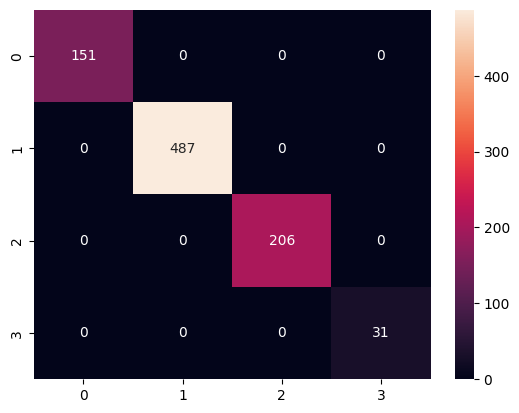

In [135]:
Y_pred = model.predict(X_train)
conMat = confusion_matrix(Y_train, Y_pred)
print(conMat)
sns.heatmap(conMat, annot=True, fmt='g') 

stability check:

In [118]:
n = 5
testscores = np.zeros((n))
trainscores = np.zeros((n))
# model:
model = LogisticRegression(random_state=0, max_iter=500, multi_class="multinomial", n_jobs=-1, C=0.001, class_weight='balanced')

for i in range(n):
    # rand = random.randint(0, 100)
    
    # shuffle and split
    X, Y = shuffle(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    # scale:
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # fit and score
    model.fit(X_train, Y_train)
    print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred))
    testscores[i] = model.score(X_test, Y_test)
    trainscores[i] = model.score(X_train, Y_train)

print("test scores: ", testscores)
print("mean: ", testscores.mean())
print("STD: ", testscores.std())
print("train scores: ", trainscores)
print("mean: ", trainscores.mean())
print("STD: ", trainscores.std())
    

              precision    recall  f1-score   support

           0       0.18      0.16      0.17        43
           1       0.53      0.61      0.57       114
           2       0.29      0.25      0.27        57
           3       0.00      0.00      0.00         5

    accuracy                           0.42       219
   macro avg       0.25      0.26      0.25       219
weighted avg       0.39      0.42      0.40       219

              precision    recall  f1-score   support

           0       0.13      0.12      0.13        40
           1       0.59      0.61      0.60       126
           2       0.15      0.15      0.15        46
           3       0.00      0.00      0.00         7

    accuracy                           0.41       219
   macro avg       0.22      0.22      0.22       219
weighted avg       0.39      0.41      0.40       219

              precision    recall  f1-score   support

           0       0.15      0.18      0.17        33
           1       0.